In [1]:
import pandas as pd

df = pd.read_csv("/Users/giovanni-lunetta/stat_4185/final_project/data/cleaned.csv")
df = df.drop("Unnamed: 0", axis=1)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/giovanni-lunetta/stat_4185/final_project/data/cleaned.csv'

In [2]:
# Import necessary libraries
from sklearn import datasets # to retrieve the iris Dataset
from sklearn.preprocessing import StandardScaler # to standardize the features
from sklearn.decomposition import PCA # to apply PCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# cast the 'MVP' and 'HOF' columns to string
df['MVP'] = df['MVP'].astype(str)
df['HOF'] = df['HOF'].astype(str)

# select the continuous variables
X = df.select_dtypes(include=['float64', 'int64'])

# split into training and testing sets
X_train, X_test = train_test_split(X, test_size=0.3, random_state=42)

In [4]:
cov_mat = np.cov(X_train.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

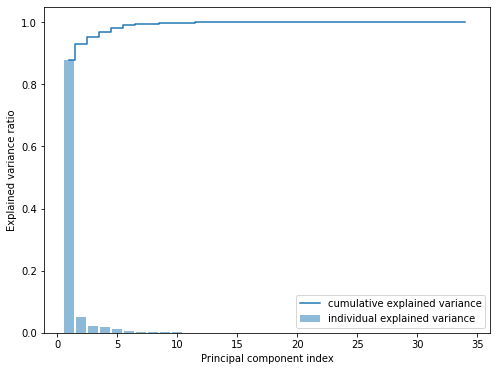

In [5]:
import numpy as np

# calculate cumulative sum of explained variances
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

# create a new figure object with size (8,6)
fig = plt.figure(figsize=(8,6))

# plot explained variances
plt.bar(range(1,35), var_exp, alpha=0.5,
        align='center', label='individual explained variance')
plt.step(range(1,35), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

In [6]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

In [7]:
# w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
#                eigen_pairs[1][1][:, np.newaxis]))
# print('Matrix W:\n', w)

w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis],
               eigen_pairs[2][1][:, np.newaxis]))
print('Matrix W:\n', w)

Matrix W:
 [[ 6.40224350e-02  3.13111729e-02  1.43227961e-01]
 [ 2.88033181e-02  6.56822181e-02  2.07142023e-01]
 [ 9.94082128e-03  2.62884319e-02  1.78276637e-01]
 [ 1.45837745e-02  8.65919257e-02  3.51929329e-01]
 [ 9.72623830e-03 -9.18333474e-03  1.69829037e-01]
 [ 1.42121582e-02 -1.34407816e-02  3.25627041e-01]
 [ 1.48851297e-04  3.53670589e-02  8.68372633e-03]
 [ 4.23321780e-04  9.97865540e-02  2.62174470e-02]
 [ 9.70154886e-03  2.15100661e-02  1.07030076e-01]
 [ 1.24424318e-02  1.56127278e-02  1.33752929e-01]
 [ 2.31906410e-03 -3.80945193e-02  2.01244570e-02]
 [ 1.07048407e-02 -4.08955896e-02  6.62172424e-02]
 [ 1.33036633e-02 -1.03283966e-01  9.12075597e-02]
 [ 8.73114566e-03  1.39518808e-01 -5.94776684e-02]
 [ 1.92836534e-03  2.31514036e-02 -7.23808724e-03]
 [ 2.28657008e-03 -1.72942636e-02  1.60250794e-02]
 [ 3.28152672e-03  3.77889894e-02  2.27005207e-02]
 [-4.47537632e-04 -1.89753316e-02  1.66627019e-02]
 [ 2.95855084e-02  1.08992259e-01  4.72354615e-01]
 [ 1.88703518e-04 -1

In [8]:
# transform the first sample vector onto the PCA subspace
x = X_train.iloc[0, :]
x_pca = x.dot(w)

# transform the entire training dataset onto the PCA subspace
X_train_pca = X_train.dot(w)

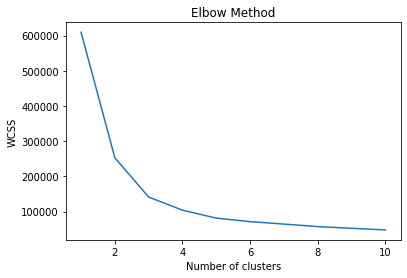

In [9]:
# fit k-means models with a range of values for the number of clusters
from sklearn.cluster import KMeans

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans.fit(X_train_pca)
    wcss.append(kmeans.inertia_)

# plot the elbow curve
import matplotlib.pyplot as plt

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [11]:
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(X_train_pca)

# predict the clusters for the training data
y_train_pred = kmeans.predict(X_train_pca)

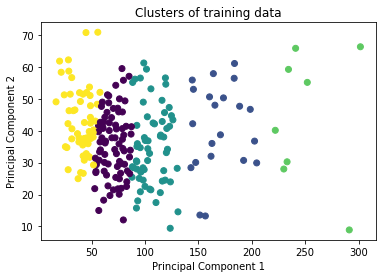

In [55]:
# # assign cluster labels to each data point
# y_train_labels = kmeans.labels_

# # convert X_train_pca to a NumPy array
# X_train_pca_array = X_train_pca.to_numpy()

# # create a scatter plot of the first two principal components with color-coded clusters
# plt.scatter(X_train_pca_array[:, 0], X_train_pca_array[:, 1], c=y_train_labels)
# plt.title('Clusters of training data')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.show()

In [12]:
import plotly.graph_objs as go

# create the trace for each cluster
cluster_traces = []
for i in range(5):
    cluster_data = X_train_pca[y_train_pred == i]
    trace = go.Scatter3d(x=cluster_data.iloc[:, 0], y=cluster_data.iloc[:, 1], z=cluster_data.iloc[:, 2], 
                         mode='markers', name='Cluster {}'.format(i), showlegend=True)
    cluster_traces.append(trace)

# create the layout for the plot
layout = go.Layout(
    title='K-Means Clustering of NBA Player Statistics',
    scene=dict(
        xaxis=dict(title='Principal Component 1'),
        yaxis=dict(title='Principal Component 2'),
        zaxis=dict(title='Principal Component 3')
    ),
    hovermode='closest'
)

# create the figure object and add the traces and layout
fig = go.Figure(data=cluster_traces, layout=layout)

# show the plot
fig.show()

Ref: https://towardsdatascience.com/principal-component-analysis-for-dimensionality-reduction-115a3d157bad